# RUL Prediction

In [1]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import graphviz
import datetime
import utils
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def compile_data(fileNames, bearingCount):
    
    compiled_dataset = pd.DataFrame()
    
    for file in fileNames:
        fileData = pd.read_csv(file)
#         print(fileData)
        fileData['BearingNumber'] = bearingCount
#         fileData['TimeStamp'] = pd.to_datetime(fileData['Time'], unit='s')
        compiled_dataset = pd.concat([compiled_dataset, fileData])
        bearingCount+=1

    compiled_dataset['index'] = np.arange(compiled_dataset.shape[0])
    
    return compiled_dataset

In [3]:
def get_data(dataType,sensor_direction,BearingNumbers):
#     dataType = 'LEARNING'
    data_set = pd.DataFrame()
    for condition in [1,2,3]:
        for BearingNumber in BearingNumbers:
            bearing = []
            for direction in [sensor_direction]:
                if (condition ==3) & (BearingNumber >3):
                    continue
                path = 'Features/{} SET/{} acceleration Features/Features{}_{}_{}.csv'.format(dataType,
                                                                                             direction,
                                                                                             condition,
                                                                                             BearingNumber,
                                                                                             direction)

                df = pd.read_csv(path)
                df['condition'] = str(condition)
                df['BearingNumber'] = BearingNumber
                if dataType == 'LEARNING':
                    df['RUL'] = df['Time'].max() - df['Time']
                    df = df[:-1]
                data_set = pd.concat([data_set, df])
    data_set = data_set.drop(columns = 'Time')
    data_set = pd.get_dummies(data_set,columns=['condition'],drop_first=True)
    if dataType == 'LEARNING':
        data_set = data_set.drop(columns='RUL').assign(RUL = data_set.RUL).sample(frac=1).reset_index(drop=True)
    return data_set.set_index('BearingNumber',drop=True).drop(columns = ['SpectralKurtosisMean',
                                                                         'SpectralKurtosisStandardDeviation',
                                                       'SpectralKurtosisSkewness', 'SpectralKurtosisKurtosis',
                                                       'SpectralEntropyMean', 'SpectralEntropyStandardDeviation',
                                                       'SpectralEntropySkewness', 'SpectralEntropyKurtosis','CustomFeature3'])

In [4]:
learning_dataset_Horizontal = get_data('LEARNING','Horizontal',[1,2])

In [5]:
learning_dataset_Horizontal.head()

,Mean,StandardDev,RMS,AbsMean,Skewness,Kurtosis,Variance,MaxValue,MinValue,Peak2Peak,...,PulseIndex,MarginIndex,SkewnessIndex,KurtosisIndex,CustomFeature1,CustomFeature2,SquareRootAmplitude,condition_2,condition_3,RUL
BearingNumber,,,,,,,,,,,,,,,,,,,,,
1,-0.043770,0.188084,0.193039,0.151968,-0.073425,3.072427,0.035376,0.682826,0.000277,0.682549,...,4.493220,3.537250,-11.035327,2455.103627,8.144197,0.198123,0.127480,1,0,7000
2,0.036818,0.198925,0.202227,0.160552,-0.059178,3.159029,0.039571,0.743772,0.000571,0.743202,...,4.632599,3.677913,-7.517885,2017.437775,7.717168,0.205584,0.135989,1,0,7280
1,-0.007743,0.404402,0.404318,0.311147,0.466905,4.437679,0.163541,2.015632,0.000021,2.015611,...,6.478072,4.985265,7.059751,165.921845,4.177170,0.404234,0.260366,0,0,13510
1,0.004173,0.362726,0.362609,0.285306,-0.063744,3.227975,0.131570,1.285684,0.000232,1.285451,...,4.506328,3.545651,-1.335669,186.472081,4.456116,0.362491,0.239559,0,0,13340
1,0.013880,0.541417,0.541383,0.409585,-0.013878,4.237243,0.293132,2.369091,0.000510,2.368581,...,5.784119,4.375996,-0.087446,49.312398,3.227325,0.541350,0.337092,0,0,10930


In [6]:
learning_dataset_Horizontal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7528 entries, 1 to 1
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mean                 7528 non-null   float64
 1   StandardDev          7528 non-null   float64
 2   RMS                  7528 non-null   float64
 3   AbsMean              7528 non-null   float64
 4   Skewness             7528 non-null   float64
 5   Kurtosis             7528 non-null   float64
 6   Variance             7528 non-null   float64
 7   MaxValue             7528 non-null   float64
 8   MinValue             7528 non-null   float64
 9   Peak2Peak            7528 non-null   float64
 10  WaveformIndex        7528 non-null   float64
 11  PeakIndex            7528 non-null   float64
 12  PulseIndex           7528 non-null   float64
 13  MarginIndex          7528 non-null   float64
 14  SkewnessIndex        7528 non-null   float64
 15  KurtosisIndex        7528 non-null   floa

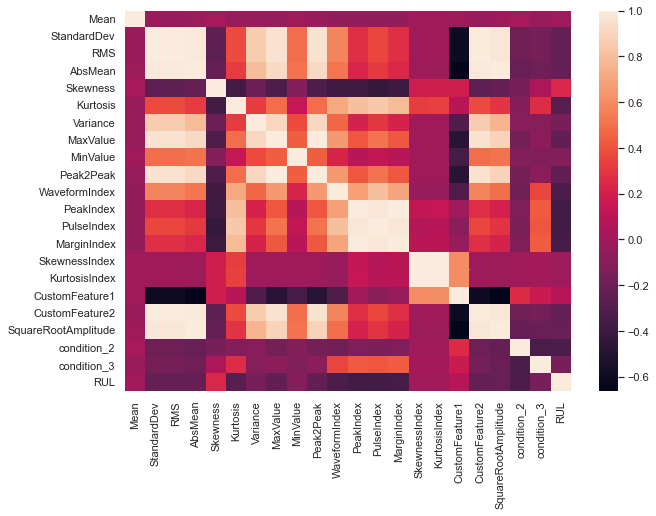

In [7]:
import seaborn as sns
plt.figure(figsize=(10,7))
correlation_matrix = learning_dataset_Horizontal.corr()
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns)

## Machine Learning Model
Before we use that feature matrix to make predictions, we should check how well guessing does on this dataset. We can use a `train_test_split` from scikit-learn to split our training data once and for all.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [9]:
X = learning_dataset_Horizontal.drop(columns='RUL').values
y = learning_dataset_Horizontal['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17,train_size=0.8)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Applying Kernal PCA

In [11]:
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(17,kernel='poly',degree=2)
X_train =transformer.fit_transform(X_train)

# Step 3: Using the Model
Now, we can use our created features to fit a `RandomForestRegressor` to our data and see if we can improve on the previous scores.

In [12]:
reg = RandomForestRegressor(n_estimators=20,random_state=13)
reg.fit(X_train, y_train)

preds = reg.predict(transformer.transform(scaler.transform(X_test)))
print(preds)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))

# high_imp_feats = utils.feature_importances(X, reg, feats=10)

[ 5231.  11264.   5888.  ...  4208.   6710.5 17395. ]
Mean Abs Error: 2761.74


In [13]:
reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

## Test set

In [14]:
#getting the data from files
Test_dataset_Horizontal = get_data('TEST','Horizontal',[3,4,5,6,7])

In [15]:
Test_dataset_Horizontal.head()

,Mean,StandardDev,RMS,AbsMean,Skewness,Kurtosis,Variance,MaxValue,MinValue,Peak2Peak,...,PeakIndex,PulseIndex,MarginIndex,SkewnessIndex,KurtosisIndex,CustomFeature1,CustomFeature2,SquareRootAmplitude,condition_2,condition_3
BearingNumber,,,,,,,,,,,,,,,,,,,,,
3,0.001197,0.248041,0.247947,0.194288,0.127733,3.599890,0.061524,1.059120,0.000230,1.058889,...,4.269934,5.451299,4.271553,8.370141,951.028464,6.571034,0.247853,0.163393,0,0
3,0.000199,0.196699,0.196623,0.153003,-0.102710,3.333085,0.038691,0.705695,0.000970,0.704725,...,3.587685,4.612298,3.589085,-13.495921,2226.564363,8.402403,0.196546,0.127285,0,0
3,0.011329,0.211226,0.211448,0.166751,-0.033351,3.152589,0.044617,0.745239,0.000005,0.745233,...,3.528152,4.469166,3.524461,-3.538908,1583.706800,7.596444,0.211669,0.140391,0,0
3,0.008143,0.181924,0.182035,0.146024,-0.123512,2.824974,0.033096,0.603649,0.000164,0.603485,...,3.318135,4.133898,3.316110,-20.513412,2579.007526,8.531803,0.182147,0.124053,0,0
3,0.004238,0.197688,0.197656,0.154482,0.106867,3.478887,0.039080,0.748696,0.000084,0.748612,...,3.787268,4.846502,3.787877,13.832693,2277.834672,8.283716,0.197624,0.129281,0,0


In [16]:
#predict RUL for every record
Test_dataset_Horizontal['predicted_RUL'] = reg.predict(transformer.transform(scaler.transform(Test_dataset_Horizontal)))
Test_dataset_Horizontal['predicted_RUL'].head()

BearingNumber
3    17681.0
3    17261.0
3    17460.5
3    11851.5
3    22589.0
Name: predicted_RUL, dtype: float64

In [17]:
#reset condition
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 0)&
                           (Test_dataset_Horizontal.condition_3 == 0),'condition'] = '1'
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 1)&
                           (Test_dataset_Horizontal.condition_3 == 0),'condition'] = '2'
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 0)&
                           (Test_dataset_Horizontal.condition_3 == 1),'condition'] = '3'

In [18]:
#get the RUL for each bearing number as minium value
Test_dataset_Horizontal.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].min()

,BearingNumber,condition,predicted_RUL
0,3,1,1784.5
1,4,1,197.0
2,5,1,1717.5
3,6,1,1226.0
4,7,1,1616.5
5,3,2,201.5
6,4,2,1378.0
7,5,2,538.0
8,6,2,919.0
9,7,2,2202.5


In [19]:
#get the RUL for each bearing number as last value
result = Test_dataset_Horizontal.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].min()

In [20]:
result['RUL'] = [5730,339 ,1610 ,1460,7570 ,7530 ,1390,3090 ,1290, 580,820]

result['%ERi'] = 100 * (result['RUL']  - result['predicted_RUL'] ) /result['RUL']

In [21]:
def cal_score(value):
    if value < 0:
        Ai = np.exp(-np.log(0.5)*(value/5))
    else:
        Ai = np.exp(np.log(0.5)*(value/20))
    return Ai

## Score

In [22]:
result['%ERi'].map(cal_score).mean()

0.3077126510667621

# XGboost

In [23]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=20, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [24]:
model = model.fit(X_train,y_train)

In [25]:
#getting the data from files
Test_dataset_Horizontal = get_data('TEST','Horizontal',[3,4,5,6,7])

In [26]:
#predict RUL for every record
Test_dataset_Horizontal['predicted_RUL'] = model.predict(transformer.transform(scaler.transform(Test_dataset_Horizontal)))
Test_dataset_Horizontal['predicted_RUL'].head()

BearingNumber
3    14559.528320
3    13940.472656
3    16199.590820
3    15673.600586
3    18742.564453
Name: predicted_RUL, dtype: float32

In [27]:
#reset condition
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 0)&
                           (Test_dataset_Horizontal.condition_3 == 0),'condition'] = '1'
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 1)&
                           (Test_dataset_Horizontal.condition_3 == 0),'condition'] = '2'
Test_dataset_Horizontal.loc[(Test_dataset_Horizontal.condition_2 == 0)&
                           (Test_dataset_Horizontal.condition_3 == 1),'condition'] = '3'

In [28]:
#get the RUL for each bearing number as minium value
Test_dataset_Horizontal.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].min()

,BearingNumber,condition,predicted_RUL
0,3,1,1341.761108
1,4,1,-139.395828
2,5,1,1744.564697
3,6,1,1044.218140
4,7,1,2378.655029
5,3,2,-774.101257
6,4,2,1363.719238
7,5,2,215.750473
8,6,2,590.996887
9,7,2,3004.226807


In [29]:
#get the RUL for each bearing number as last value
result = Test_dataset_Horizontal.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].min()

In [30]:
result['RUL'] = [5730,339 ,1610 ,1460,7570 ,7530 ,1390,3090 ,1290, 580,820]

result['%ERi'] = 100 * (result['RUL']  - result['predicted_RUL'] ) /result['RUL']

In [31]:
result['%ERi'].map(cal_score).mean()

0.18567316263891429